<a id='top'></a>
---

# Re-Read Dynamic Data Clip After It Has Already Been Read By Another Master
* Language: Python 3.7  
* Author: Leo Bach 7/2/2020
* Version: 1
* Email: leo@machinesaver.net  
* Phone: +1(832)581-9908

In [1]:
# import neccessary libraries
import minimalmodbus                        # modbus master library which supports Modbus RTU & Modbus ASCII but not Modbus TCP
import serial.tools.list_ports              # only used to find COM Port of your USB to RS485 Converter
import time                                 # use sleep to wait while sensor processes are happening + used to take timestamp when data is collected
from datetime import datetime               # manipulate timestamp to human readable date
import math                                 # used to manipulate numbers
import os                                   # used to save snapshots to snapshot directory within Machine Saver's Jupyter notebook

# import the neccessary libraries
import matplotlib.pyplot as plt            # charting library
from scipy.fftpack import fft               # fast fourier transform algorithm
import numpy as np                          # number manipulation - for creating time arrays and frequency bins arrays
from deepdiff import DeepDiff  # For Deep Difference of 2 objects
from pprint import pprint
import json

In [2]:
# Find connected COM Ports Windows (RS485 to USB Converter)
ports = list(serial.tools.list_ports.comports())
if len(ports)==0:
    print('Please Plug A USB to RS485 Serial Converter in to Computer')
else:
    for p in ports:
        print (p)

/dev/ttyUSB0 - FT232R USB UART


<a id="part2"></a>
---

## Part 2 --- Slave Addresses/RTU Number & Communication Settings
1. By convention Machine Saver produces Tri-Vibe Sensors with Slave Addresses matching the last 2 digits of the Tri-Vibe's serial number (we reserve slave address 0 and 1 for Modbus Masters and only increment from 2 - 99).
2. Update ```PORT = 'COM3'``` in the module below to match the location of your USB to RS485 Serial Converter.  
    * ```/dev/ttyUSB0``` (Linux)  
    * ```/dev/tty.usbserial``` (OS X)  
    * ```COM4``` (Windows)
3. Update ```SLAVE_ADDRESS = 72``` in the module below to the Slave Address of the Tri-Vibe.
4. Re-Run this Notebook after editing.

Note: It is possible to [Change the Tri-Vibe Slave Address](#part4) 

In [3]:
PORT = '/dev/ttyUSB0'
SLAVE_ADDRESS = 11

if(SLAVE_ADDRESS!=0):
    trivibe = minimalmodbus.Instrument(PORT, SLAVE_ADDRESS)    # create a Modbus Slave object for the Tri-Vibe
else:
    print('Your SLAVE_ADDRESS should not be zero! Please change the value to the slave address of your Tri-Vibe.')

In [4]:
# update current slave settings for Tri-Vibe defaults and some useful variables
trivibe.serial.port                        # this is the serial port name
trivibe.address                            # this is the slave address (set this to the last 2 digits of the serial number of the Tri-Vibe that you want to communicate with)
trivibe.serial.baudrate = 115200           # Baudrate fixed 115200
trivibe.serial.bytesize = 8                # Bytesize fixed 8
trivibe.serial.parity   = "N"              # Parity fixed None 
trivibe.serial.stopbits = 1                # Stopbits fixed 1
trivibe.serial.timeout  = 0.10             # Seconds
trivibe.close_port_after_each_call = True  # Helps communication for Windows Devices (can be set to false on many Linux devices)
trivibe.mode = minimalmodbus.MODE_RTU      # modbus mode fixed RTU Mode
trivibe.clear_buffers_before_each_transaction = True


print(trivibe)                             # check updated slave communication settings

minimalmodbus.Instrument<id=0x7f9c1395f150, address=11, mode=rtu, close_port_after_each_call=True, precalculate_read_size=True, clear_buffers_before_each_transaction=True, handle_local_echo=False, debug=False, serial=Serial<id=0x7f9c142ac6d0, open=True>(port='/dev/ttyUSB0', baudrate=115200, bytesize=8, parity='N', stopbits=1, timeout=0.1, xonxoff=False, rtscts=False, dsrdtr=False)>


In [5]:
serial = trivibe.read_long(26, functioncode=3)

In [6]:
length_of_capture = trivibe.read_registers(35, 1, functioncode=3)

In [7]:
internal_accel = trivibe.read_registers(32, 1, functioncode=3)

In [8]:
samples_per_axis = trivibe.read_long(36, functioncode=3, signed=False, byteorder=0)

In [9]:
try:
    s1_a1_sensitivity = trivibe.read_float(299, functioncode=3, number_of_registers=2, byteorder=0)
    s1_a2_sensitivity = trivibe.read_float(301, functioncode=3, number_of_registers=2, byteorder=0)
    s1_a3_sensitivity = trivibe.read_float(303, functioncode=3, number_of_registers=2, byteorder=0)
    s2_a1_sensitivity = trivibe.read_float(305, functioncode=3, number_of_registers=2, byteorder=0)
    s2_a2_sensitivity = trivibe.read_float(307, functioncode=3, number_of_registers=2, byteorder=0)
    s2_a3_sensitivity = trivibe.read_float(309, functioncode=3, number_of_registers=2, byteorder=0)
except IOError:
    print('Failed to read from Tri-Vibe')

In [10]:
# Set Sample Registers Back to Zero
trivibe.write_long(18, 0, signed=False, byteorder=0)

# Initiate Load Command to Control Register
trivibe.write_register(1, 3)

In [11]:
timestamp = int(str(time.time())[slice(10)])                            # metadata to be used when displaying our charts to users, removes the portion of the timestamp beyond seconds
snapshotTime = datetime.fromtimestamp(timestamp)                        # convert it to human readable format

## Part 10 --- Analysis Data Capture Command & Verify Completion (Register 33-34)  
Tell the Tri-Vibe to start capturing data based on the specified parameters from part 9 (Register 33)
Check Tri-Vibe capture engine to see if the collection is complete (Register 34)

### Check Tri-Vibe Capture Engine Status (Register 34)  

| Status | Capture Engine Status                                                    |
|--------|--------------------------------------------------------------------------|
| 0      | IDLE. Doing nothing                                                      |
| 1      | CAPTURING DONE. Data is collected and ready to be read by client.        |
| 2      | IN PROGRESS. Actively collect data accordingly to configured parameters. |
| 3      | START ERROR. Something was going wrong. Bad parameters.                  |
| 4      | TIMEOUT ERROR. Something was going wrong.                                |


In [12]:
try:
    capture_engine_status = trivibe.read_registers(34, 1, functioncode=3)
    print('capture_engine_status: '+str(capture_engine_status[0]))           # show capture engine is busy (in progress)
except IOError:
    print('Failed to read from Tri-Vibe')
while capture_engine_status[0]==2:                                           # wait for data capture on the Tri-Vibe to complete
    capture_engine_status = trivibe.read_registers(34, 1, functioncode=3)
    time.sleep(2)
try:
    capture_engine_status = trivibe.read_registers(34, 1, functioncode=3)
    print('capture_engine_status: '+str(capture_engine_status[0]))           # show capture engine is complete (capturing done)
except IOError:
    print('Failed to read from Tri-Vibe')


capture_engine_status: 0
capture_engine_status: 0


<a id="part11"></a>
---

## Part 11 --- Gather Captured Analysis Data From Tri-Vibe and Split into 3 Axis
#### Data Array
* The Tri-Vibe orders the samples that it has collected as: axis_1_samples, axis_2_samples, axis_3_samples.  
* Samples can be read 122 samples at a time by reading modbus registers 50-171.  
* AUTOLOAD: when register 171 is successfully read, if there are more snapshot samples stored in the Tri-Vibe, the same set of registers (50-171) will be loaded with the next set of samples.
* Therefore if you had 122 samples_per_axis:  
    1. the first time reading registers 50-171 would return the entire sample set for Axis 1  
    2. after the successful read, the next 122 samples would be loaded into the modbus registers 50-171  
    3. the second time reading registers 50-171 would return the entire sample set for Axis 2  
    4. after the successful read, the next 122 samples would be loaded into the modbus registers 50-171  
    5. the thirds time reading registers 50-171 would return the entire sample set for Axis 3  

In [13]:
total_number_of_samples = samples_per_axis*3                              # how many samples are stored on the Tri-Vibe's buffer.
read_sets_required = math.ceil(total_number_of_samples/122)               # number of times we need to read Modbus Registers 50-171 to get all our samples back from our sensor

raw_data =[]                                                             # where we will store 3 axis of RAW vibration data from the Tri-Vibe's internal accelerometer

while len(raw_data)<total_number_of_samples:
    try:
        read_set = trivibe.read_registers(49, 123, functioncode=3)             # register_number, number_of_registers, function_code
        read_set.pop(0)                                                        # remove register 49 from read_set
        raw_data.extend(read_set)                                            # take all values from the read_set and add them to our data array
    except IOError:
        print('Failed to read from Tri-Vibe')

raw_data = raw_data[0:total_number_of_samples]                             # remove any trailing zeroes from the last read_set

axis_1_data_array_RAW = raw_data[0:samples_per_axis]                             # split data into 3 axes arrays
axis_2_data_array_RAW = raw_data[samples_per_axis:samples_per_axis*2]
axis_3_data_array_RAW = raw_data[samples_per_axis*2:samples_per_axis*3]

# Save Data in JSON

In [14]:
# Data to be written  
dictionary ={
    "chunk_index": 4,
    "last_index": 4,
    "serial_number": serial,
    "timestamp": timestamp,
    "samples_per_axis_36": samples_per_axis,
    "capture_time_ms_35": length_of_capture[0],
    "internal_accelerometer_32": internal_accel[0],
    "s1_a1_sensitivity": s1_a1_sensitivity,
    "s1_a2_sensitivity": s1_a2_sensitivity,
    "s1_a3_sensitivity": s1_a3_sensitivity,
    "s2_a1_sensitivity": s2_a1_sensitivity,
    "s2_a2_sensitivity": s2_a2_sensitivity,
    "s2_a3_sensitivity": s2_a3_sensitivity,
    "raw_samples": raw_data
}

with open("sample_reread.json", "w") as outfile:  
    json.dump(dictionary, outfile)

# Compare to Original File

In [15]:
with open('./sample.json')as f:
    data = json.load(f)
with open('./sample_reread.json')as f:
    data_reread = json.load(f)
    
pprint(DeepDiff(data, data_reread))


{'iterable_item_removed': {"root['raw_samples'][196608]": 0,
                           "root['raw_samples'][196609]": 0,
                           "root['raw_samples'][196610]": 0,
                           "root['raw_samples'][196611]": 0,
                           "root['raw_samples'][196612]": 0,
                           "root['raw_samples'][196613]": 0,
                           "root['raw_samples'][196614]": 0,
                           "root['raw_samples'][196615]": 0,
                           "root['raw_samples'][196616]": 0,
                           "root['raw_samples'][196617]": 0,
                           "root['raw_samples'][196618]": 0,
                           "root['raw_samples'][196619]": 0,
                           "root['raw_samples'][196620]": 0,
                           "root['raw_samples'][196621]": 0,
                           "root['raw_samples'][196622]": 0,
                           "root['raw_samples'][196623]": 0,
                        

<a id="part12"></a>
---

## Part 12 --- Analysis Data RAW to Acceleration Conversion

Written Conversion Instructions
1. Above we split the RAW data into 3 arrays (one for each axis) and each of the 3 axis array has to be processed individually.
2. Get the Highest_Value and Lowest_Value from the RAW data Axis array.
3. Calculate the Virtual_Center_Line of the array:  
```Virtual_Center_Line = (Highest_Value-Lowest_Value)/2+ Lowest_Value```
4. The next steps need to be done for each item (sample) in the array:
5. Find the Difference from the Virtual Center Line  
If Raw_ADC_Value > Virtual_Center_Line  
    ```Difference_ADU = |Raw_ADC_Value - Virtual_Center_Line|```  
If Raw_ADC_Value < Virtual_Center_Line Difference_ADU  
    ```Difference_ADU = -|Raw_ADC_Value - Virtual_Center_Line|```  
If the RAW ADC Value = Virtual Center Line  
    ```Difference_ADU = 0```  
Find the Difference_mV  
    ```Difference_mV = Difference_ADU * Constant_K```  
Find the Acceleration_Amplitude  
    ```Acceleration_Amplitude = Difference_mV / Sensitivity```  

Constant_K – it is the number of millivolts in the circuit (3000) divided by the max number of counts from a 16 bit Analog to Digital Converter (65535).

Sensitivity – it is sensitivity of each axis of each internal accelerometer which is the value saved during sensor calibration and testing process at Machine Saver Inc.
Client can read these values from sensor using following Modbus registers

### Sensitivity Registers

| Modbus Registers | Internal Accelerometer 1 | Internal Accelerometer 2 |
|:----------------:|--------------------------|--------------------------|
| Axis 1           |          299-300         |          305-306         |
| Axis 2           |          301-302         |          307-308         |
| Axis 3           |          303-304         |          309-310         |


In [16]:
# pass a data_array of RAW values and an axis to the following function to convert them to (G PK) values

def convertRAWtoACCEL(aList, axis):
    """ Converts an Axis Data Array from RAW data to Acceleration Data Array"""
    if axis == 1:
        sensitivity = trivibe.read_float(299, functioncode=3, number_of_registers=2, byteorder=0)
    elif axis == 2:
        sensitivity = trivibe.read_float(301, functioncode=3, number_of_registers=2, byteorder=0)
    elif axis == 3:
        sensitivity = trivibe.read_float(303, functioncode=3, number_of_registers=2, byteorder=0)
    elif axis == 4:
        sensitivity = trivibe.read_float(305, functioncode=3, number_of_registers=2, byteorder=0)
    elif axis == 5:
        sensitivity = trivibe.read_float(307, functioncode=3, number_of_registers=2, byteorder=0)
    elif axis == 6:
        sensitivity = trivibe.read_float(309, functioncode=3, number_of_registers=2, byteorder=0)
    
    constant_k = 3000/65535
    
    virtual_center = (max(aList)-min(aList))/2+min(aList)
    
    for position in range(len(aList)):
        if aList[position]>virtual_center:
            aList[position] = (abs(aList[position] - virtual_center)*constant_k)/sensitivity # if the value was above virtual center it will be positive for the timewave form
        elif aList[position]<virtual_center:
            aList[position] = (-abs(aList[position] - virtual_center)*constant_k)/sensitivity # if the value was below virtual center it will be negative for the timewave form
        else:
            aList[position] = 0 #if the value equals the virtual_center line we set it to zero for the timewave form

    return(aList)
    
if(internal_accel[0] == 5):                   # if internal accelerometer 1 was selected in the Analysis Data Setup Process
    axis_1_data_array_acceleration = convertRAWtoACCEL(axis_1_data_array_RAW, 1)
    axis_2_data_array_acceleration = convertRAWtoACCEL(axis_2_data_array_RAW, 2)
    axis_3_data_array_acceleration = convertRAWtoACCEL(axis_3_data_array_RAW, 3)
elif(internal_accel[0] == 6):                 # if internal accelerometer 2 was selected in the Analysis Data Setup Process
    axis_1_data_array_acceleration = convertRAWtoACCEL(axis_1_data_array_RAW, 4)
    axis_2_data_array_acceleration = convertRAWtoACCEL(axis_2_data_array_RAW, 5)
    axis_3_data_array_acceleration = convertRAWtoACCEL(axis_3_data_array_RAW, 6)
else:
    print("Internal Accelerometer Not Defined!")

<a id="part13"></a>
---

## Part 13 --- Windowing
Under Construction

<a id="part14"></a>
---

## Part 14 --- Analysis Data FFT & Charting

### Timewave Form Chart: Amplitude vs. Time  

Tri-Axial Timewave Form


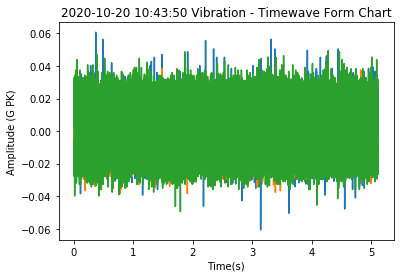

In [17]:
def chart_timewave_form(accel_data_array):
    """ Charts Axis Data Array """
    Fs = samples_per_axis/(length_of_capture[0]/1000)          # sampling frequency hertz (samples per second)
    # print(Fs)
    t = np.arange(0,length_of_capture[0]/1000,1/Fs)            # create a range of numbers from 0 to capture time (in seconds) at a specified interval (1/FrequencySampleRate)
    # print(t)
    y = accel_data_array                                       # TWF signal
    # print(y)
    plt.plot(t,y)                                              # create the timewave form plot for the generated sinewave
    plt.title(str(snapshotTime)+' Vibration - Timewave Form Chart')   
    plt.xlabel('Time(s)')                                      # time array (t) as the x-axis
    plt.ylabel('Amplitude (G PK)')                             # amplitude array (y) as the y-axis
    matrix = np.column_stack((t, y))                           # combine the x and y values into a matrix for storage in our twf snapshot file
    return matrix

print("Tri-Axial Timewave Form")
axis_1_twf = chart_timewave_form(axis_1_data_array_acceleration)             # axis 1 is blue on chart
axis_2_twf = chart_timewave_form(axis_2_data_array_acceleration)             # axis 2 is orange on chart
axis_3_twf = chart_timewave_form(axis_3_data_array_acceleration)             # axis 3 is green on chart

Axis 1 TWF


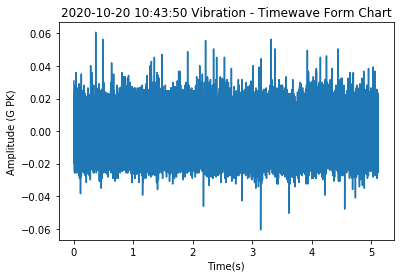

In [18]:
print("Axis 1 TWF")
axis_1_twf = chart_timewave_form(axis_1_data_array_acceleration)

Axis 2 TWF


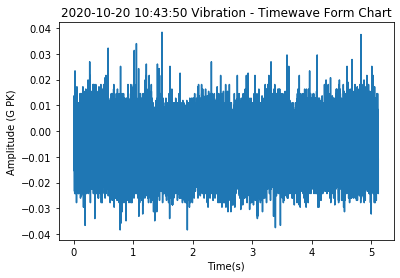

In [19]:
print("Axis 2 TWF")
axis_2_twf = chart_timewave_form(axis_2_data_array_acceleration)

Axis 3 TWF


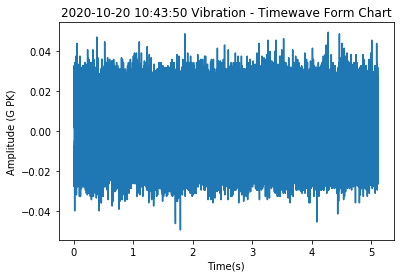

In [20]:
print("Axis 3 TWF")
axis_3_twf = chart_timewave_form(axis_3_data_array_acceleration)

Tri-Axial Spectrum


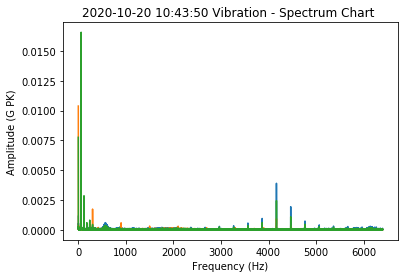

In [21]:
def transform_twf_to_spectrum(accel_data_array):
    """ Converts Acceleration data to Frequency data and then Charts the Frequency data """
    Fs = samples_per_axis/(length_of_capture[0]/1000)          # sampling frequency hertz (samples per second)
    t = np.arange(0,length_of_capture[0]/1000,1/Fs)            # create a range of numbers from 0 to capture time (in seconds) at a specified interval (1/FrequencySampleRate)
    y = accel_data_array                                       # TWF signal
    # convert twf to spectrum
    n = np.size(t) 
    Fbin = (Fs/2)*np.linspace(0,1,n//2)
    Y = fft(accel_data_array)
    Y_amplitude = (2/n)*abs(Y[0:np.size(Fbin)])
    # chart
    plt.plot(Fbin, Y_amplitude)
    plt.title(str(datetime.fromtimestamp(timestamp))+' Vibration - Spectrum Chart ')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (G PK)')
    matrix = np.column_stack((Fbin, Y_amplitude))               # combine the x and y values into a matrix for storage in our spectrum snapshot file
    return matrix

print("Tri-Axial Spectrum")
axis_1_spectrum = transform_twf_to_spectrum(axis_1_data_array_acceleration)             # axis 1 is blue on chart
axis_2_spectrum = transform_twf_to_spectrum(axis_2_data_array_acceleration)             # axis 2 is orange on chart
axis_3_spectrum = transform_twf_to_spectrum(axis_3_data_array_acceleration)             # axis 3 is green on chart

Axis 1 Spectrum


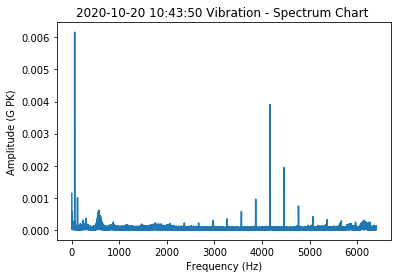

In [22]:
print("Axis 1 Spectrum")
axis_1_spectrum = transform_twf_to_spectrum(axis_1_data_array_acceleration)

Axis 2 Spectrum


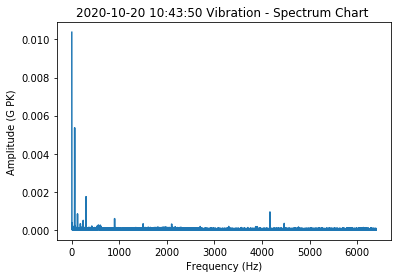

In [23]:
print("Axis 2 Spectrum")
axis_2_spectrum = transform_twf_to_spectrum(axis_2_data_array_acceleration)

Axis 3 Spectrum


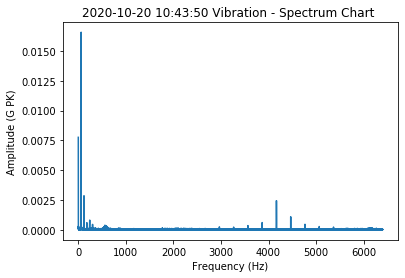

In [24]:
print("Axis 3 Spectrum")
axis_3_spectrum = transform_twf_to_spectrum(axis_3_data_array_acceleration)